In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from ripser import ripser
from persim import plot_diagrams
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""Import dataset"""

# Import data
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [3]:
"""Preprocess Data: Remove Duplicates and Missing Values"""

# Check initial counts
initial_count = X.shape[0]

# Remove duplicates
X_clean = X.drop_duplicates()
y_clean = y.loc[X_clean.index]
duplicates_removed = initial_count - X_clean.shape[0]

# Remove missing values
after_duplicates = X_clean.shape[0]
mask = ~X_clean.isnull().any(axis=1)
X_clean = X_clean[mask]
y_clean = y_clean[mask]
missing_removed = after_duplicates - X_clean.shape[0]

# Summary
print(f"Original shape: {initial_count}")
print(f"Duplicates removed: {duplicates_removed}")
print(f"Missing values removed: {missing_removed}")
print(f"Total removed: {duplicates_removed + missing_removed}")
print(f"Cleaned shape: {X_clean.shape[0]}")

# Update X and y
X = X_clean.reset_index(drop=True)
y = y_clean.reset_index(drop=True)

Original shape: 303
Duplicates removed: 0
Missing values removed: 6
Total removed: 6
Cleaned shape: 297


In [4]:
"""Standardize the Features"""

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns) # Convert back to DataFrame

In [5]:
"""Compute Euclidean distance matrix"""

distance_matrix = pairwise_distances(X_scaled, metric='euclidean')


H0 (connected components): 297 features
H1 (loops/cycles): 261 features
H2 (voids): 182 features


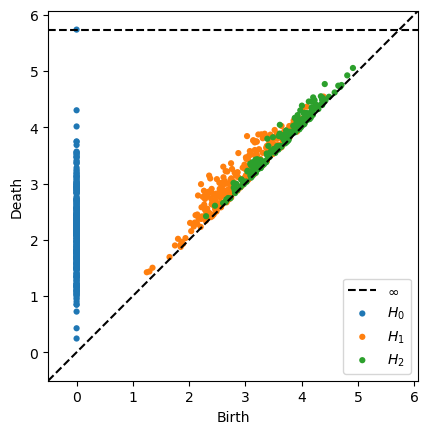

In [6]:
"""Vietoris-Rips Filtration and Persistent Homology Computation"""

# Vietoris-Rips filtration set-up
max_dimension = 2  # Up to 2-dimensional homology (H0, H1, H2)
max_edge_length = np.percentile(distance_matrix[distance_matrix > 0], 50)  # Use median distance

# Compute persistent homology
result = ripser(distance_matrix, maxdim=max_dimension, distance_matrix=True)

# Extract persistence diagrams
diagrams = result['dgms']

# Print out H0, H1, H2
print(f"\nH0 (connected components): {len(diagrams[0])} features")
print(f"H1 (loops/cycles): {len(diagrams[1])} features")
print(f"H2 (voids): {len(diagrams[2])} features")

# Plot persistence diagrams
plot_diagrams(diagrams, show=True)

Stable Rank (Betti) curves computed!
Epsilon range: [0, 4.9730] with 100 steps


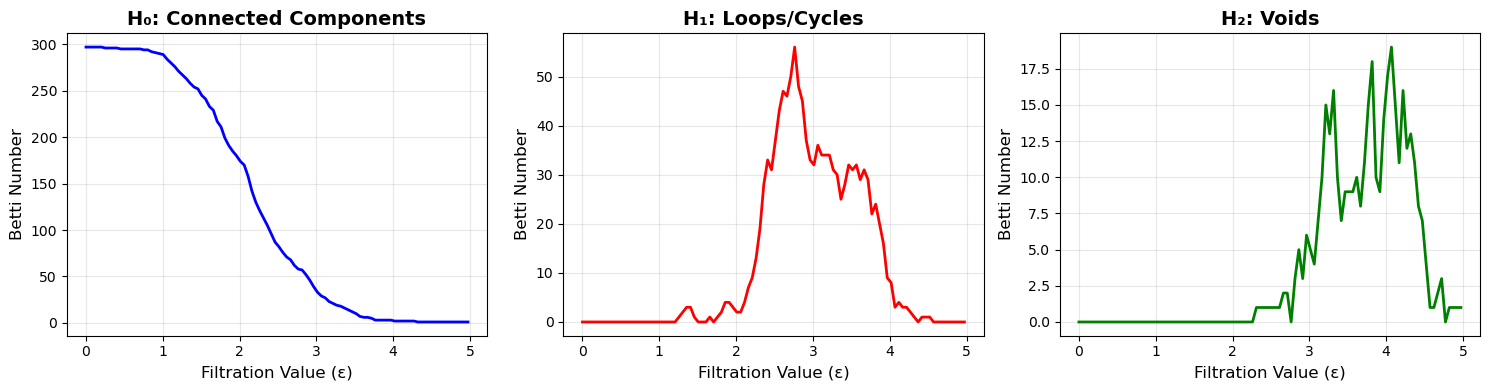

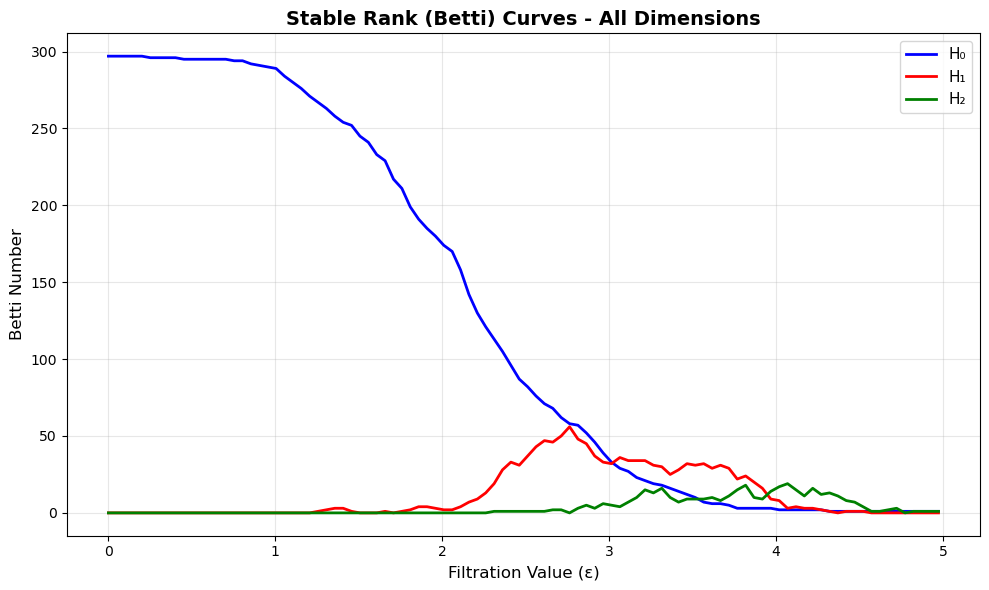

In [7]:
"""Stable Rank (Betti) Curves Computation and Visualization"""

# Filtration scales
epsilon_values = np.linspace(0, max_edge_length, 100)

# Compute Betti numbers 
betti_0 = [np.sum((diagrams[0][:,0] <= eps) & (diagrams[0][:,1] > eps)) for eps in epsilon_values]
betti_1 = [np.sum((diagrams[1][:,0] <= eps) & (diagrams[1][:,1] > eps)) for eps in epsilon_values]
betti_2 = [np.sum((diagrams[2][:,0] <= eps) & (diagrams[2][:,1] > eps)) for eps in epsilon_values] if len(diagrams) > 2 else []

print("Stable Rank (Betti) curves computed!")
print(f"Epsilon range: [0, {max_edge_length:.4f}] with {len(epsilon_values)} steps")

# Plot individual Betti curves
titles = ['H₀: Connected Components', 'H₁: Loops/Cycles', 'H₂: Voids']
colors = ['b', 'r', 'g']
bettis = [betti_0, betti_1, betti_2]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axes):
    if i < len(bettis) and len(bettis[i]) > 0:
        ax.plot(epsilon_values, bettis[i], colors[i] + '-', linewidth=2)
    else:
        ax.text(0.5, 0.5, 'No features', ha='center', va='center')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Filtration Value (ε)', fontsize=12)
    ax.set_ylabel('Betti Number', fontsize=12)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Combined plot
plt.figure(figsize=(10, 6))
for i in range(len(bettis)):
    if len(bettis[i]) > 0:
        plt.plot(epsilon_values, bettis[i], colors[i] + '-', linewidth=2, label=titles[i].split(":")[0])
plt.xlabel('Filtration Value (ε)', fontsize=12)
plt.ylabel('Betti Number', fontsize=12)
plt.title('Stable Rank (Betti) Curves - All Dimensions', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
"""L1 Distance (Persistence aka lifetimes) computation for each homology dimension"""

# H0
persistence_0 = diagrams[0][:, 1] - diagrams[0][:, 0]
persistence_0 = persistence_0[np.isfinite(persistence_0)]

# H1
persistence_1 = diagrams[1][:, 1] - diagrams[1][:, 0]
persistence_1 = persistence_1[np.isfinite(persistence_1)]

# H2
persistence_2 = diagrams[2][:, 1] - diagrams[2][:, 0]
persistence_2 = persistence_2[np.isfinite(persistence_2)]

# Print
print("\nL1 Distances (Persistence Lifetimes):")
print(f"H0 persistence — Mean: {persistence_0.mean():.4f}, Min: {persistence_0.min():.4f}, Max: {persistence_0.max():.4f}")
print(f"H1 persistence — Mean: {persistence_1.mean():.4f}, Min: {persistence_1.min():.4f}, Max: {persistence_1.max():.4f}")
print(f"H2 persistence — Mean: {persistence_2.mean():.4f}, Min: {persistence_2.min():.4f}, Max: {persistence_2.max():.4f}")



L1 Distances (Persistence Lifetimes):
H0 persistence — Mean: 2.1493, Min: 0.2448, Max: 4.3016
H1 persistence — Mean: 0.2303, Min: 0.0005, Max: 0.8127
H2 persistence — Mean: 0.1049, Min: 0.0009, Max: 0.4307


Random Forest — Raw Data
Binary Classification Accuracy: 88.33%
Multi-Class Classification Accuracy: 60.00%


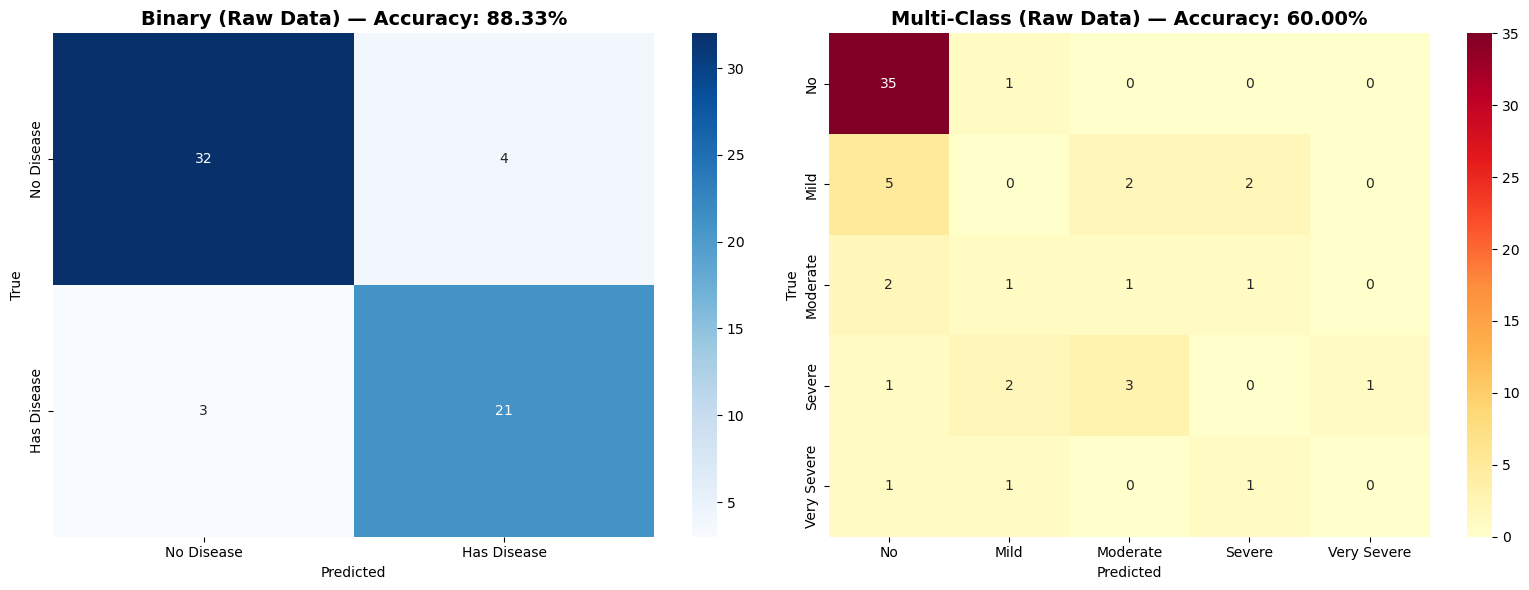

In [9]:
"""Random Forest Classification Using Raw Data"""

# Binary classification (y > 0 = has disease)
y_binary = (y > 0).astype(int)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42
)

clf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
clf_bin.fit(X_train_bin, y_train_bin)
y_pred_bin = clf_bin.predict(X_test_bin)
acc_bin = accuracy_score(y_test_bin, y_pred_bin)

# Multi-class classification (0–4 severity)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

clf_multi = RandomForestClassifier(n_estimators=100, random_state=42)
clf_multi.fit(X_train_multi, y_train_multi)
y_pred_multi = clf_multi.predict(X_test_multi)
acc_multi = accuracy_score(y_test_multi, y_pred_multi)

# Print results
print("Random Forest — Raw Data")
print(f"Binary Classification Accuracy: {acc_bin:.2%}")
print(f"Multi-Class Classification Accuracy: {acc_multi:.2%}")

# Plot confusion matrices 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Disease', 'Has Disease'],
            yticklabels=['No Disease', 'Has Disease'],
            ax=axes[0])
axes[0].set_title(f'Binary (Raw Data) — Accuracy: {acc_bin:.2%}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

# Multi-class
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
            xticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            yticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            ax=axes[1])
axes[1].set_title(f'Multi-Class (Raw Data) — Accuracy: {acc_multi:.2%}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


Random Forest — Topological Features
Binary Classification Accuracy: 50.00%
Multi-Class Classification Accuracy: 48.33%


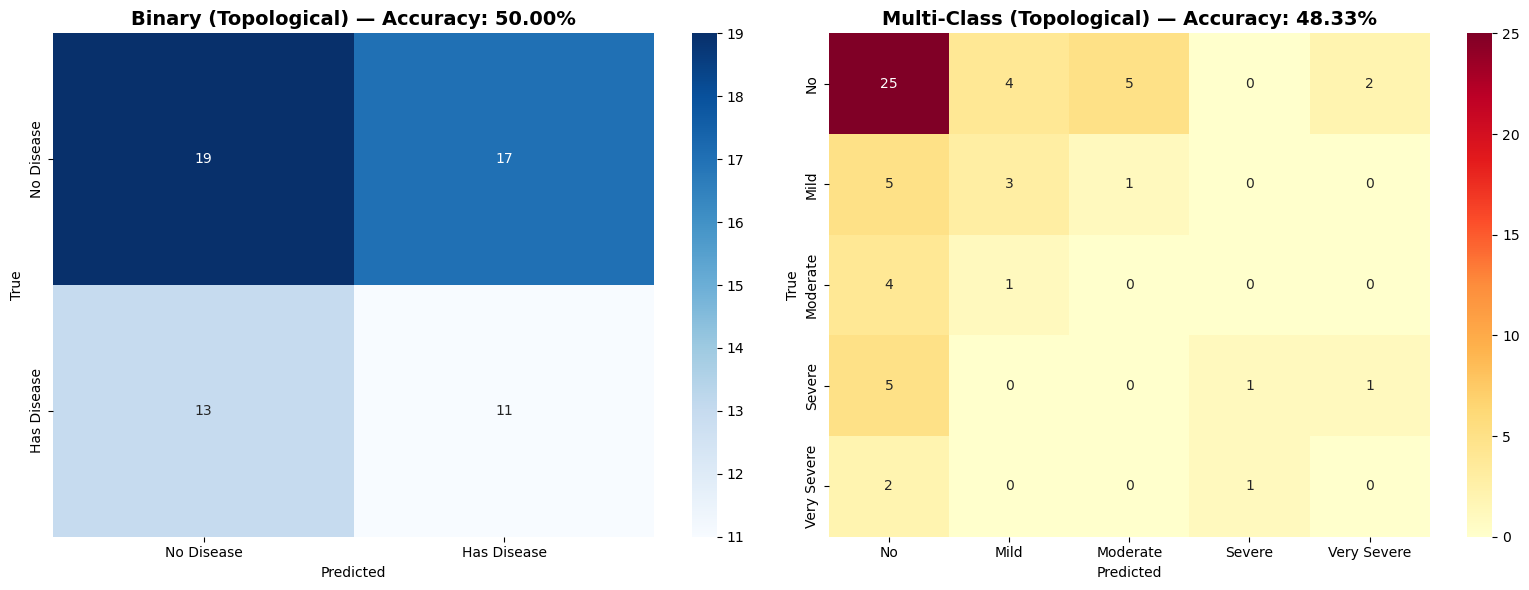

In [10]:
"""Random Forest with Topological Features"""

# Build per-sample topological features
k_neighbors = 10
X_topo = np.array([
    [
        np.mean(sorted(distance_matrix[i])[1:k_neighbors+1]),
        np.std(sorted(distance_matrix[i])[1:k_neighbors+1]),
        np.min(sorted(distance_matrix[i])[1:k_neighbors+1]),
        np.max(sorted(distance_matrix[i])[1:k_neighbors+1]),
        np.median(sorted(distance_matrix[i])[1:k_neighbors+1])
    ]
    for i in range(distance_matrix.shape[0])
])

y_binary = (y > 0).astype(int)

# Binary 
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_topo, y_binary, test_size=0.2, random_state=42)
clf_b = RandomForestClassifier(n_estimators=100, random_state=42)
clf_b.fit(X_train_b, y_train_b)
y_pred_b = clf_b.predict(X_test_b)
acc_b = accuracy_score(y_test_b, y_pred_b)

# Multi-class
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_topo, y, test_size=0.2, random_state=42)
clf_m = RandomForestClassifier(n_estimators=100, random_state=42)
clf_m.fit(X_train_m, y_train_m)
y_pred_m = clf_m.predict(X_test_m)
acc_m = accuracy_score(y_test_m, y_pred_m)

# Print accuracy results
print("Random Forest — Topological Features")
print(f"Binary Classification Accuracy: {acc_b:.2%}")
print(f"Multi-Class Classification Accuracy: {acc_m:.2%}")


# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary
cm_b = confusion_matrix(y_test_b, y_pred_b)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Disease', 'Has Disease'],
            yticklabels=['No Disease', 'Has Disease'], ax=axes[0])
axes[0].set_title(f'Binary (Topological) — Accuracy: {acc_b:.2%}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

# Multi-class
cm_m = confusion_matrix(y_test_m, y_pred_m)
sns.heatmap(cm_m, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
            xticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            yticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'], ax=axes[1])
axes[1].set_title(f'Multi-Class (Topological) — Accuracy: {acc_m:.2%}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

# Clusters and Subgroups

CLUSTERING PATIENT SUBGROUPS USING TDA FEATURES

Using 297 patients with 5 TDA features
TDA features: ['Mean k-NN', 'Std k-NN', 'Min k-NN', 'Max k-NN', 'Median k-NN']

What these TDA features mean:
  • Mean k-NN: Average distance to 10 nearest neighbors
  • Std k-NN: How varied those distances are
  • Min/Max/Median k-NN: Range of neighbor distances

→ Patients with similar distance patterns = similar topological position

Evaluating different numbers of clusters...
  k=2: silhouette score = 0.516
  k=3: silhouette score = 0.453
  k=4: silhouette score = 0.400
  k=5: silhouette score = 0.370
  k=6: silhouette score = 0.345
  k=7: silhouette score = 0.343
  k=8: silhouette score = 0.348


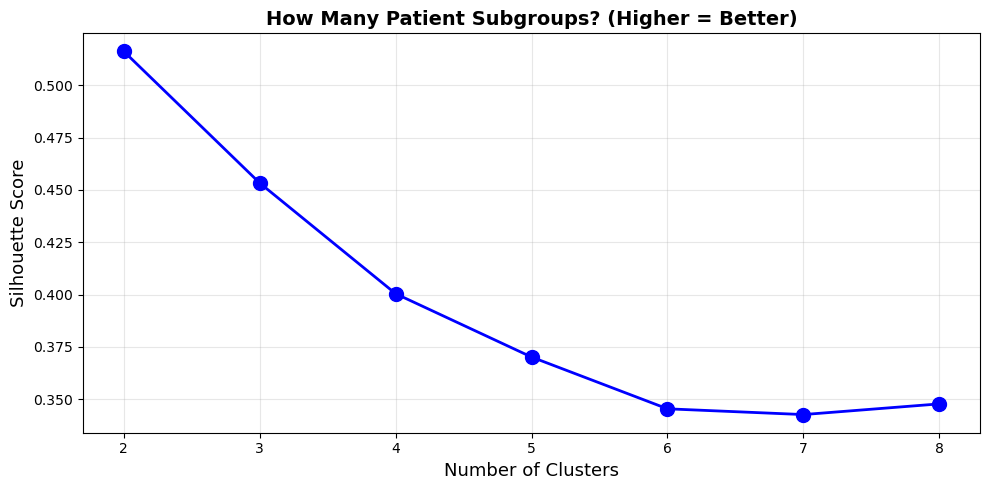


→ Optimal number of clusters: 2


In [11]:
"""Simple Clustering Using TDA Features - WITH CLEAR EXPLANATIONS"""

# Use only the TDA features we already computed
print("="*80)
print("CLUSTERING PATIENT SUBGROUPS USING TDA FEATURES")
print("="*80)

# TDA features (already computed earlier in your code)
tda_feature_names = ['Mean k-NN', 'Std k-NN', 'Min k-NN', 'Max k-NN', 'Median k-NN']
print(f"\nUsing {X_topo.shape[0]} patients with {X_topo.shape[1]} TDA features")
print(f"TDA features: {tda_feature_names}")
print("\nWhat these TDA features mean:")
print("  • Mean k-NN: Average distance to 10 nearest neighbors")
print("  • Std k-NN: How varied those distances are")
print("  • Min/Max/Median k-NN: Range of neighbor distances")
print("\n→ Patients with similar distance patterns = similar topological position")

y_flat = y.values.ravel() if hasattr(y, 'values') else y


"""Step 1: Find Optimal Number of Clusters"""

from sklearn.metrics import calinski_harabasz_score

K_range = range(2, 9)
silhouette_scores = []

print("\nEvaluating different numbers of clusters...")
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_topo)
    sil_score = silhouette_score(X_topo, labels_temp)
    silhouette_scores.append(sil_score)
    print(f"  k={k}: silhouette score = {sil_score:.3f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Number of Clusters', fontsize=13)
plt.ylabel('Silhouette Score', fontsize=13)
plt.title('How Many Patient Subgroups? (Higher = Better)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n→ Optimal number of clusters: {optimal_k}")

In [12]:
"""Step 2: Cluster Patients Using TDA Features"""

# You can change this number to explore different groupings
num_clusters = 4

print(f"\nClustering into {num_clusters} subgroups...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_topo)

print("\nPatient distribution:")
for i in range(num_clusters):
    n = np.sum(clusters == i)
    print(f"  Subgroup {i}: {n} patients ({n/len(clusters)*100:.1f}%)")



Clustering into 4 subgroups...

Patient distribution:
  Subgroup 0: 74 patients (24.9%)
  Subgroup 1: 75 patients (25.3%)
  Subgroup 2: 44 patients (14.8%)
  Subgroup 3: 104 patients (35.0%)


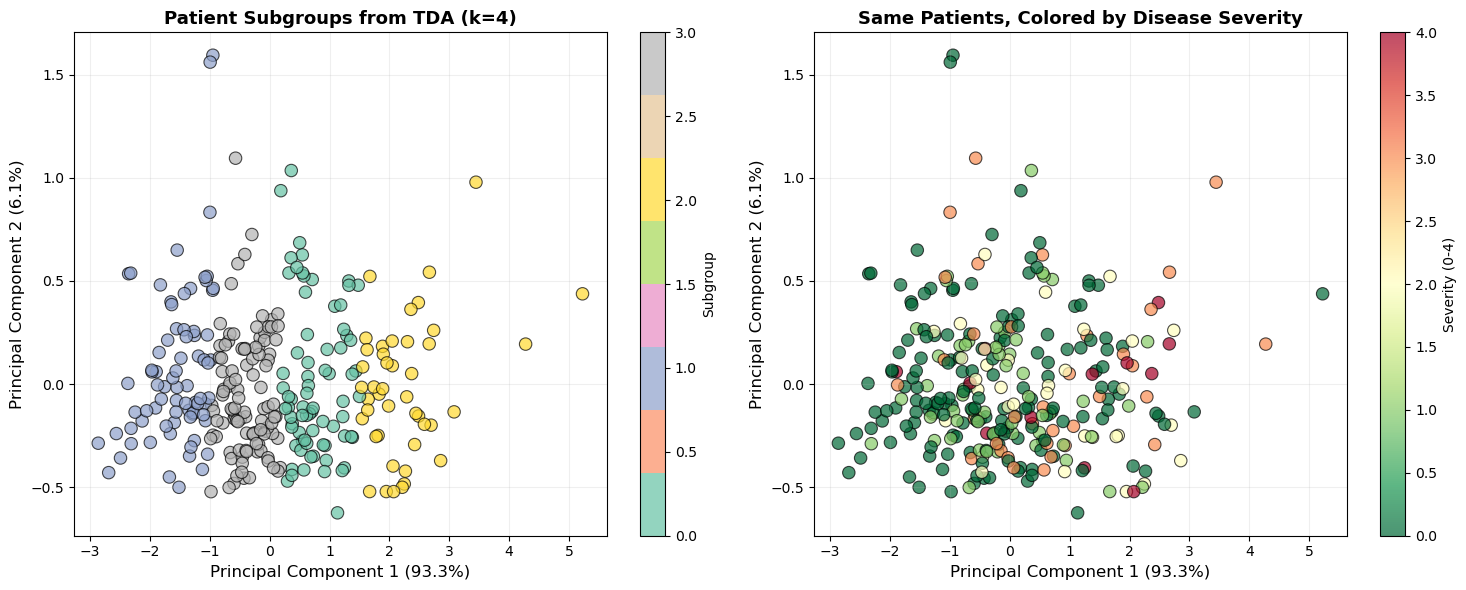

In [13]:
"""Step 3: Visualize the Subgroups"""

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_topo)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left: colored by cluster
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, 
                          cmap='Set2', s=80, alpha=0.7, edgecolors='black', linewidth=0.8)
axes[0].set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[0].set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[0].set_title(f'Patient Subgroups from TDA (k={num_clusters})', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.2)
plt.colorbar(scatter1, ax=axes[0], label='Subgroup')

# Right: colored by disease severity
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_flat, 
                          cmap='RdYlGn_r', s=80, alpha=0.7, edgecolors='black', linewidth=0.8)
axes[1].set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[1].set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[1].set_title('Same Patients, Colored by Disease Severity', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.2)
plt.colorbar(scatter2, ax=axes[1], label='Severity (0-4)')

plt.tight_layout()
plt.show()


WHY THESE CLUSTERS? (TDA EXPLANATION)

Cluster centroids (what defines each cluster in TDA space):

  Cluster 0 TDA Profile:
    Mean k-NN: 3.1113
    Std k-NN: 0.3332
    Min k-NN: 2.4076
    Max k-NN: 3.4793
    Median k-NN: 3.1990

  Cluster 1 TDA Profile:
    Mean k-NN: 1.9548
    Std k-NN: 0.3645
    Min k-NN: 1.2036
    Max k-NN: 2.3771
    Median k-NN: 2.0221

  Cluster 2 TDA Profile:
    Mean k-NN: 3.8638
    Std k-NN: 0.3197
    Min k-NN: 3.1697
    Max k-NN: 4.1929
    Median k-NN: 3.9628

  Cluster 3 TDA Profile:
    Mean k-NN: 2.5291
    Std k-NN: 0.3132
    Min k-NN: 1.8840
    Max k-NN: 2.8734
    Median k-NN: 2.6170


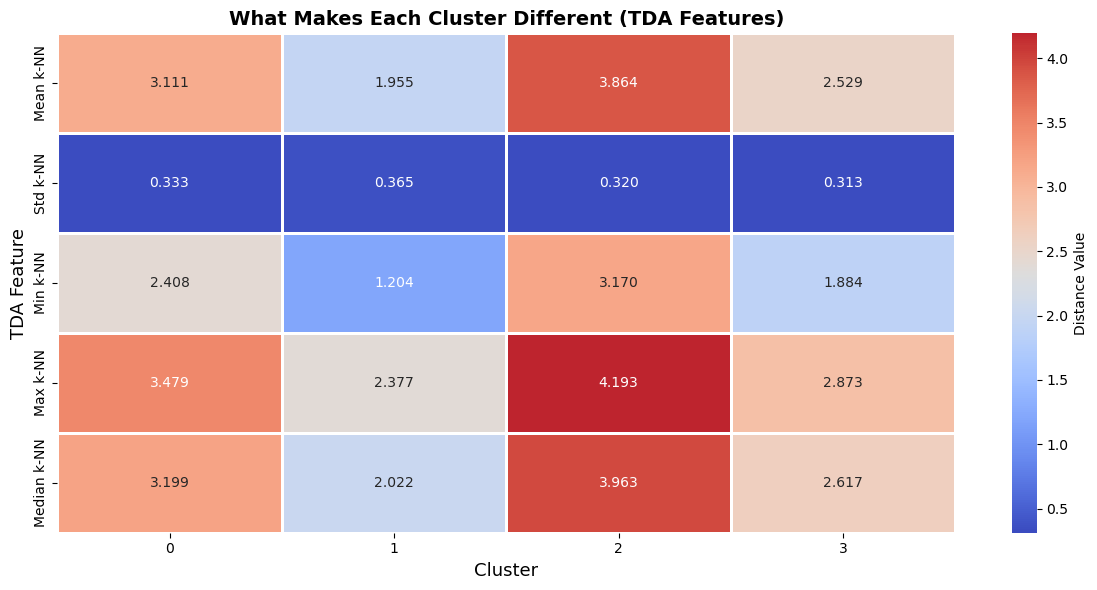


--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------

Cluster 0:
  → ISOLATED patients (high mean k-NN = 3.111)
     These patients are OUTLIERS - far from other patients in feature space

Cluster 1:
  → DENSE core patients (low mean k-NN = 1.955)
     These patients are SIMILAR to many others - in a dense region

Cluster 2:
  → ISOLATED patients (high mean k-NN = 3.864)
     These patients are OUTLIERS - far from other patients in feature space

Cluster 3:
  → TYPICAL density (mean k-NN = 2.529)
     These patients are in moderately dense regions


In [14]:

"""Step 3.5: EXPLAIN WHAT MAKES EACH CLUSTER UNIQUE (TDA PERSPECTIVE)"""

print("\n" + "="*80)
print("WHY THESE CLUSTERS? (TDA EXPLANATION)")
print("="*80)

tda_df = pd.DataFrame(X_topo, columns=tda_feature_names)
tda_df['Cluster'] = clusters

print("\nCluster centroids (what defines each cluster in TDA space):")
cluster_centers = kmeans.cluster_centers_

for i in range(num_clusters):
    print(f"\n  Cluster {i} TDA Profile:")
    for j, feat_name in enumerate(tda_feature_names):
        print(f"    {feat_name}: {cluster_centers[i][j]:.4f}")

# Visual comparison
plt.figure(figsize=(12, 6))
tda_summary = tda_df.groupby('Cluster').mean()
sns.heatmap(tda_summary.T, annot=True, fmt='.3f', cmap='coolwarm', 
            cbar_kws={'label': 'Distance Value'}, linewidths=1, center=tda_summary.values.mean())
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('TDA Feature', fontsize=13)
plt.title('What Makes Each Cluster Different (TDA Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "-"*80)
print("INTERPRETATION:")
print("-"*80)
overall_mean_knn = X_topo[:, 0].mean()
for i in range(num_clusters):
    cluster_mean_knn = cluster_centers[i][0]
    cluster_std_knn = cluster_centers[i][1]
    
    print(f"\nCluster {i}:")
    if cluster_mean_knn > overall_mean_knn * 1.1:
        print(f"  → ISOLATED patients (high mean k-NN = {cluster_mean_knn:.3f})")
        print(f"     These patients are OUTLIERS - far from other patients in feature space")
    elif cluster_mean_knn < overall_mean_knn * 0.9:
        print(f"  → DENSE core patients (low mean k-NN = {cluster_mean_knn:.3f})")
        print(f"     These patients are SIMILAR to many others - in a dense region")
    else:
        print(f"  → TYPICAL density (mean k-NN = {cluster_mean_knn:.3f})")
        print(f"     These patients are in moderately dense regions")
    
    if cluster_std_knn > X_topo[:, 1].mean() * 1.1:
        print(f"     High variability (std = {cluster_std_knn:.3f}) = heterogeneous neighborhood")
    elif cluster_std_knn < X_topo[:, 1].mean() * 0.9:
        print(f"     Low variability (std = {cluster_std_knn:.3f}) = uniform neighborhood")


In [15]:

"""Step 4: NOW MAP TO CLINICAL FEATURES"""

# Feature descriptions
FEATURE_INFO = {
    'age': ('Age', 'years', 'continuous'),
    'sex': ('Sex', '1=male, 0=female', 'categorical'),
    'cp': ('Chest Pain Type', '1-4', 'categorical'),
    'trestbps': ('Resting Blood Pressure', 'mm Hg', 'continuous'),
    'chol': ('Cholesterol', 'mg/dl', 'continuous'),
    'fbs': ('High Fasting Blood Sugar', '1=yes, 0=no', 'categorical'),
    'restecg': ('Resting ECG', '0-2', 'categorical'),
    'thalach': ('Max Heart Rate', 'bpm', 'continuous'),
    'exang': ('Exercise Angina', '1=yes, 0=no', 'categorical'),
    'oldpeak': ('ST Depression', 'units', 'continuous'),
    'slope': ('ST Slope', '1-3', 'categorical'),
    'ca': ('Major Vessels', '0-3', 'categorical'),
    'thal': ('Thalassemia', '3/6/7', 'categorical')
}

print("\n" + "="*80)
print("WHAT CLINICAL FEATURES CHARACTERIZE EACH CLUSTER?")
print("="*80)
print("(Remember: clusters are formed by TDA, but here's what those clusters look like clinically)")

for cluster_id in range(num_clusters):
    mask = clusters == cluster_id
    
    print(f"\n{'━'*80}")
    print(f"CLUSTER {cluster_id}: {mask.sum()} patients ({mask.sum()/len(clusters)*100:.1f}%)")
    print(f"{'━'*80}")
    
    # Disease severity in this cluster
    severity = y_flat[mask]
    print(f"\n  Disease Severity Distribution:")
    for sev in range(5):
        count = np.sum(severity == sev)
        if count > 0:
            print(f"    Level {sev}: {count} patients ({count/len(severity)*100:.1f}%)")
    avg_sev = severity.mean()
    print(f"    → Average severity: {avg_sev:.2f}", end="")
    if avg_sev > y_flat.mean() + 0.3:
        print(" (HIGHER than average)")
    elif avg_sev < y_flat.mean() - 0.3:
        print(" (LOWER than average)")
    else:
        print(" (similar to average)")
    
    # Demographics
    print(f"\n  Demographics:")
    if 'age' in X.columns:
        age_mean = X.loc[mask, 'age'].mean()
        age_overall = X['age'].mean()
        print(f"    Age: {age_mean:.1f} years", end="")
        if abs(age_mean - age_overall) > 5:
            print(f" ({'older' if age_mean > age_overall else 'younger'} than avg {age_overall:.1f})")
        else:
            print(f" (similar to avg)")
    
    if 'sex' in X.columns:
        male_pct = (X.loc[mask, 'sex'] == 1).sum() / mask.sum() * 100
        overall_male_pct = (X['sex'] == 1).sum() / len(X) * 100
        print(f"    Gender: {male_pct:.0f}% male", end="")
        if abs(male_pct - overall_male_pct) > 15:
            print(f" ({'MORE' if male_pct > overall_male_pct else 'LESS'} male than avg {overall_male_pct:.0f}%)")
        else:
            print(f" (similar to avg)")
    
    # Key clinical features that define this cluster
    print(f"\n  Defining Clinical Features (what makes this cluster unique):")
    
    differences = []
    for col in X.columns:
        if col in FEATURE_INFO and FEATURE_INFO[col][2] == 'continuous':
            group_mean = X.loc[mask, col].mean()
            overall_mean = X[col].mean()
            overall_std = X[col].std()
            
            if overall_std > 0:
                diff_sigma = (group_mean - overall_mean) / overall_std
                
                if abs(diff_sigma) > 0.5:
                    name, unit, _ = FEATURE_INFO[col]
                    direction = "HIGHER" if diff_sigma > 0 else "LOWER"
                    differences.append((abs(diff_sigma), f"{name}: {group_mean:.1f} {unit} ({direction}, {abs(diff_sigma):.1f}σ from avg)"))
    
    # Show top 5 most distinctive features
    differences.sort(reverse=True)
    if differences:
        for rank, (_, desc) in enumerate(differences[:5], 1):
            print(f"    {rank}. {desc}")
    else:
        print(f"    • No major differences from population average")
    
    # Categorical features that stand out
    print(f"\n  Categorical Feature Patterns:")
    for col in ['cp', 'exang', 'ca']:
        if col in X.columns:
            cluster_mode = X.loc[mask, col].mode()[0] if len(X.loc[mask, col].mode()) > 0 else None
            mode_pct = (X.loc[mask, col] == cluster_mode).sum() / mask.sum() * 100 if cluster_mode is not None else 0
            
            if mode_pct > 60:  # If more than 60% have same value
                name, _, _ = FEATURE_INFO[col]
                print(f"    • {name}: {mode_pct:.0f}% have value {int(cluster_mode)}")




WHAT CLINICAL FEATURES CHARACTERIZE EACH CLUSTER?
(Remember: clusters are formed by TDA, but here's what those clusters look like clinically)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
CLUSTER 0: 74 patients (24.9%)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Disease Severity Distribution:
    Level 0: 37 patients (50.0%)
    Level 1: 14 patients (18.9%)
    Level 2: 8 patients (10.8%)
    Level 3: 12 patients (16.2%)
    Level 4: 3 patients (4.1%)
    → Average severity: 1.05 (similar to average)

  Demographics:
    Age: 57.8 years (similar to avg)
    Gender: 70% male (similar to avg)

  Defining Clinical Features (what makes this cluster unique):
    • No major differences from population average

  Categorical Feature Patterns:
    • Exercise Angina: 62% have value 0

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
CLUSTER 1: 75 patients (25.3%)
━━━━━━━━━━━━━━━━━━━━━━━━


SIDE-BY-SIDE CLUSTER COMPARISON

  Cluster   N  Avg_Severity   Avg_Age  Pct_Male  Mean_kNN_Dist   Avg_Chol     Avg_BP
       0  74      1.054054 57.797297 70.270270       3.111295 246.959459 133.567568
       1  75      0.413333 49.546667 58.666667       1.954755 239.520000 124.693333
       2  44      1.545455 58.363636 61.363636       3.863774 268.363636 142.409091
       3 104      1.000000 54.211538 75.000000       2.529068 244.384615 130.875000

--------------------------------------------------------------------------------
KEY INSIGHTS:
--------------------------------------------------------------------------------
• Cluster 1 = healthiest group (avg severity 0.41)
• Cluster 2 = most severe group (avg severity 1.55)
• Cluster 2 = most ISOLATED topologically (outliers)
• Cluster 1 = most DENSE topologically (typical patients)


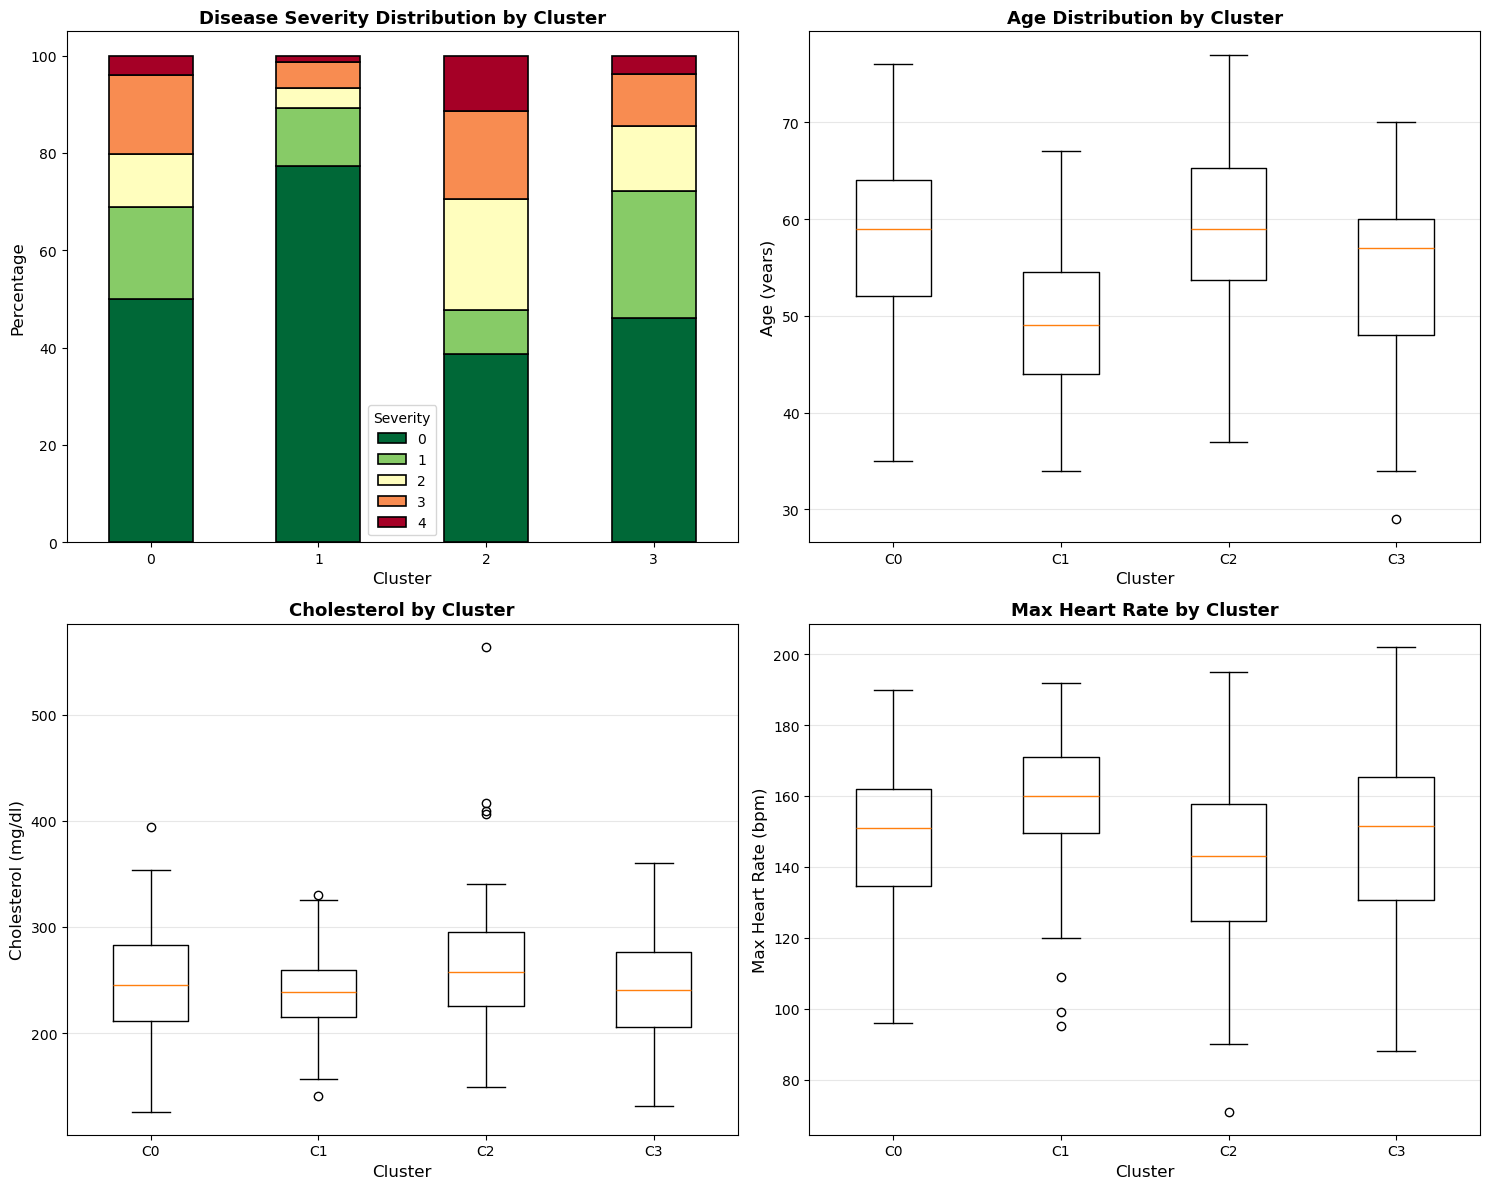

In [16]:

"""Step 5: Side-by-Side Comparison"""

# Show key stats for all clusters side by side
print("\n" + "="*80)
print("SIDE-BY-SIDE CLUSTER COMPARISON")
print("="*80)

comparison_stats = []
for cluster_id in range(num_clusters):
    mask = clusters == cluster_id
    
    stats = {
        'Cluster': cluster_id,
        'N': mask.sum(),
        'Avg_Severity': y_flat[mask].mean(),
        'Avg_Age': X.loc[mask, 'age'].mean() if 'age' in X.columns else 0,
        'Pct_Male': (X.loc[mask, 'sex'] == 1).sum() / mask.sum() * 100 if 'sex' in X.columns else 0,
        'Mean_kNN_Dist': X_topo[mask, 0].mean(),
        'Avg_Chol': X.loc[mask, 'chol'].mean() if 'chol' in X.columns else 0,
        'Avg_BP': X.loc[mask, 'trestbps'].mean() if 'trestbps' in X.columns else 0,
    }
    comparison_stats.append(stats)

comparison_df = pd.DataFrame(comparison_stats)
print("\n", comparison_df.to_string(index=False))

print("\n" + "-"*80)
print("KEY INSIGHTS:")
print("-"*80)

# Find most distinctive cluster
severity_range = comparison_df['Avg_Severity'].max() - comparison_df['Avg_Severity'].min()
if severity_range > 0.5:
    healthiest = comparison_df.loc[comparison_df['Avg_Severity'].idxmin(), 'Cluster']
    sickest = comparison_df.loc[comparison_df['Avg_Severity'].idxmax(), 'Cluster']
    print(f"• Cluster {int(healthiest)} = healthiest group (avg severity {comparison_df.loc[int(healthiest), 'Avg_Severity']:.2f})")
    print(f"• Cluster {int(sickest)} = most severe group (avg severity {comparison_df.loc[int(sickest), 'Avg_Severity']:.2f})")

# Find most isolated/dense
most_isolated = comparison_df.loc[comparison_df['Mean_kNN_Dist'].idxmax(), 'Cluster']
most_dense = comparison_df.loc[comparison_df['Mean_kNN_Dist'].idxmin(), 'Cluster']
print(f"• Cluster {int(most_isolated)} = most ISOLATED topologically (outliers)")
print(f"• Cluster {int(most_dense)} = most DENSE topologically (typical patients)")


"""Step 6: Visual Comparison"""

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Disease severity by cluster
severity_by_cluster = pd.crosstab(clusters, y_flat, normalize='index') * 100
severity_by_cluster.plot(kind='bar', stacked=True, colormap='RdYlGn_r', 
                         edgecolor='black', linewidth=1.2, ax=axes[0,0])
axes[0,0].set_xlabel('Cluster', fontsize=12)
axes[0,0].set_ylabel('Percentage', fontsize=12)
axes[0,0].set_title('Disease Severity Distribution by Cluster', fontsize=13, fontweight='bold')
axes[0,0].legend(title='Severity', labels=['0', '1', '2', '3', '4'])
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=0)

# 2. Age distribution
age_data = [X.loc[clusters == i, 'age'].values for i in range(num_clusters)] if 'age' in X.columns else []
if age_data:
    axes[0,1].boxplot(age_data, labels=[f'C{i}' for i in range(num_clusters)])
    axes[0,1].set_xlabel('Cluster', fontsize=12)
    axes[0,1].set_ylabel('Age (years)', fontsize=12)
    axes[0,1].set_title('Age Distribution by Cluster', fontsize=13, fontweight='bold')
    axes[0,1].grid(True, alpha=0.3, axis='y')

# 3. Cholesterol
chol_data = [X.loc[clusters == i, 'chol'].values for i in range(num_clusters)] if 'chol' in X.columns else []
if chol_data:
    axes[1,0].boxplot(chol_data, labels=[f'C{i}' for i in range(num_clusters)])
    axes[1,0].set_xlabel('Cluster', fontsize=12)
    axes[1,0].set_ylabel('Cholesterol (mg/dl)', fontsize=12)
    axes[1,0].set_title('Cholesterol by Cluster', fontsize=13, fontweight='bold')
    axes[1,0].grid(True, alpha=0.3, axis='y')

# 4. Max heart rate
hr_data = [X.loc[clusters == i, 'thalach'].values for i in range(num_clusters)] if 'thalach' in X.columns else []
if hr_data:
    axes[1,1].boxplot(hr_data, labels=[f'C{i}' for i in range(num_clusters)])
    axes[1,1].set_xlabel('Cluster', fontsize=12)
    axes[1,1].set_ylabel('Max Heart Rate (bpm)', fontsize=12)
    axes[1,1].set_title('Max Heart Rate by Cluster', fontsize=13, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



In [17]:

"""Step 7: Save Results"""

results = X.copy()
results['Cluster'] = clusters
results['Disease_Severity'] = y_flat
results['Mean_kNN_Distance'] = X_topo[:, 0]

print("\n" + "="*80)
print("✓ ANALYSIS COMPLETE")
print("="*80)
print(f"\nClusters are formed based on: TOPOLOGICAL SIMILARITY (k-NN distances)")
print(f"Then we examine: What clinical features do those topological clusters have?")
print(f"\nResults saved in 'results' dataframe")


✓ ANALYSIS COMPLETE

Clusters are formed based on: TOPOLOGICAL SIMILARITY (k-NN distances)
Then we examine: What clinical features do those topological clusters have?

Results saved in 'results' dataframe


# OLD DEL LATER

In [ ]:
"""Simple Clustering Using TDA Features - WITH CLEAR EXPLANATIONS"""

# Use only the TDA features we already computed
print("="*80)
print("CLUSTERING PATIENT SUBGROUPS USING TDA FEATURES")
print("="*80)

# TDA features (already computed earlier in your code)
tda_feature_names = ['Mean k-NN', 'Std k-NN', 'Min k-NN', 'Max k-NN', 'Median k-NN']
print(f"\nUsing {X_topo.shape[0]} patients with {X_topo.shape[1]} TDA features")
print(f"TDA features: {tda_feature_names}")
print("\nWhat these TDA features mean:")
print("  • Mean k-NN: Average distance to 10 nearest neighbors")
print("  • Std k-NN: How varied those distances are")
print("  • Min/Max/Median k-NN: Range of neighbor distances")
print("\n→ Patients with similar distance patterns = similar topological position")

y_flat = y.values.ravel() if hasattr(y, 'values') else y


"""Step 1: Find Optimal Number of Clusters"""

from sklearn.metrics import calinski_harabasz_score

K_range = range(2, 9)
silhouette_scores = []

print("\nEvaluating different numbers of clusters...")
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_topo)
    sil_score = silhouette_score(X_topo, labels_temp)
    silhouette_scores.append(sil_score)
    print(f"  k={k}: silhouette score = {sil_score:.3f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Number of Clusters', fontsize=13)
plt.ylabel('Silhouette Score', fontsize=13)
plt.title('How Many Patient Subgroups? (Higher = Better)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n→ Optimal number of clusters: {optimal_k}")


"""Step 2: Cluster Patients Using TDA Features"""

# You can change this number to explore different groupings
num_clusters = 4

print(f"\nClustering into {num_clusters} subgroups...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_topo)

print("\nPatient distribution:")
for i in range(num_clusters):
    n = np.sum(clusters == i)
    print(f"  Subgroup {i}: {n} patients ({n/len(clusters)*100:.1f}%)")


"""Step 3: Visualize the Subgroups"""

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_topo)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left: colored by cluster
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, 
                          cmap='Set2', s=80, alpha=0.7, edgecolors='black', linewidth=0.8)
axes[0].set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[0].set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[0].set_title(f'Patient Subgroups from TDA (k={num_clusters})', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.2)
plt.colorbar(scatter1, ax=axes[0], label='Subgroup')

# Right: colored by disease severity
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_flat, 
                          cmap='RdYlGn_r', s=80, alpha=0.7, edgecolors='black', linewidth=0.8)
axes[1].set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[1].set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[1].set_title('Same Patients, Colored by Disease Severity', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.2)
plt.colorbar(scatter2, ax=axes[1], label='Severity (0-4)')

plt.tight_layout()
plt.show()


"""Step 3.5: EXPLAIN WHAT MAKES EACH CLUSTER UNIQUE (TDA PERSPECTIVE)"""

print("\n" + "="*80)
print("WHY THESE CLUSTERS? (TDA EXPLANATION)")
print("="*80)

tda_df = pd.DataFrame(X_topo, columns=tda_feature_names)
tda_df['Cluster'] = clusters

print("\nCluster centroids (what defines each cluster in TDA space):")
cluster_centers = kmeans.cluster_centers_

for i in range(num_clusters):
    print(f"\n  Cluster {i} TDA Profile:")
    for j, feat_name in enumerate(tda_feature_names):
        print(f"    {feat_name}: {cluster_centers[i][j]:.4f}")

# Visual comparison
plt.figure(figsize=(12, 6))
tda_summary = tda_df.groupby('Cluster').mean()
sns.heatmap(tda_summary.T, annot=True, fmt='.3f', cmap='coolwarm', 
            cbar_kws={'label': 'Distance Value'}, linewidths=1, center=tda_summary.values.mean())
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('TDA Feature', fontsize=13)
plt.title('What Makes Each Cluster Different (TDA Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "-"*80)
print("INTERPRETATION:")
print("-"*80)
overall_mean_knn = X_topo[:, 0].mean()
for i in range(num_clusters):
    cluster_mean_knn = cluster_centers[i][0]
    cluster_std_knn = cluster_centers[i][1]
    
    print(f"\nCluster {i}:")
    if cluster_mean_knn > overall_mean_knn * 1.1:
        print(f"  → ISOLATED patients (high mean k-NN = {cluster_mean_knn:.3f})")
        print(f"     These patients are OUTLIERS - far from other patients in feature space")
    elif cluster_mean_knn < overall_mean_knn * 0.9:
        print(f"  → DENSE core patients (low mean k-NN = {cluster_mean_knn:.3f})")
        print(f"     These patients are SIMILAR to many others - in a dense region")
    else:
        print(f"  → TYPICAL density (mean k-NN = {cluster_mean_knn:.3f})")
        print(f"     These patients are in moderately dense regions")
    
    if cluster_std_knn > X_topo[:, 1].mean() * 1.1:
        print(f"     High variability (std = {cluster_std_knn:.3f}) = heterogeneous neighborhood")
    elif cluster_std_knn < X_topo[:, 1].mean() * 0.9:
        print(f"     Low variability (std = {cluster_std_knn:.3f}) = uniform neighborhood")


"""Step 4: NOW MAP TO CLINICAL FEATURES"""

# Feature descriptions
FEATURE_INFO = {
    'age': ('Age', 'years', 'continuous'),
    'sex': ('Sex', '1=male, 0=female', 'categorical'),
    'cp': ('Chest Pain Type', '1-4', 'categorical'),
    'trestbps': ('Resting Blood Pressure', 'mm Hg', 'continuous'),
    'chol': ('Cholesterol', 'mg/dl', 'continuous'),
    'fbs': ('High Fasting Blood Sugar', '1=yes, 0=no', 'categorical'),
    'restecg': ('Resting ECG', '0-2', 'categorical'),
    'thalach': ('Max Heart Rate', 'bpm', 'continuous'),
    'exang': ('Exercise Angina', '1=yes, 0=no', 'categorical'),
    'oldpeak': ('ST Depression', 'units', 'continuous'),
    'slope': ('ST Slope', '1-3', 'categorical'),
    'ca': ('Major Vessels', '0-3', 'categorical'),
    'thal': ('Thalassemia', '3/6/7', 'categorical')
}

print("\n" + "="*80)
print("WHAT CLINICAL FEATURES CHARACTERIZE EACH CLUSTER?")
print("="*80)
print("(Remember: clusters are formed by TDA, but here's what those clusters look like clinically)")

for cluster_id in range(num_clusters):
    mask = clusters == cluster_id
    
    print(f"\n{'━'*80}")
    print(f"CLUSTER {cluster_id}: {mask.sum()} patients ({mask.sum()/len(clusters)*100:.1f}%)")
    print(f"{'━'*80}")
    
    # Disease severity in this cluster
    severity = y_flat[mask]
    print(f"\n  Disease Severity Distribution:")
    for sev in range(5):
        count = np.sum(severity == sev)
        if count > 0:
            print(f"    Level {sev}: {count} patients ({count/len(severity)*100:.1f}%)")
    avg_sev = severity.mean()
    print(f"    → Average severity: {avg_sev:.2f}", end="")
    if avg_sev > y_flat.mean() + 0.3:
        print(" (HIGHER than average)")
    elif avg_sev < y_flat.mean() - 0.3:
        print(" (LOWER than average)")
    else:
        print(" (similar to average)")
    
    # Demographics
    print(f"\n  Demographics:")
    if 'age' in X.columns:
        age_mean = X.loc[mask, 'age'].mean()
        age_overall = X['age'].mean()
        print(f"    Age: {age_mean:.1f} years", end="")
        if abs(age_mean - age_overall) > 5:
            print(f" ({'older' if age_mean > age_overall else 'younger'} than avg {age_overall:.1f})")
        else:
            print(f" (similar to avg)")
    
    if 'sex' in X.columns:
        male_pct = (X.loc[mask, 'sex'] == 1).sum() / mask.sum() * 100
        overall_male_pct = (X['sex'] == 1).sum() / len(X) * 100
        print(f"    Gender: {male_pct:.0f}% male", end="")
        if abs(male_pct - overall_male_pct) > 15:
            print(f" ({'MORE' if male_pct > overall_male_pct else 'LESS'} male than avg {overall_male_pct:.0f}%)")
        else:
            print(f" (similar to avg)")
    
    # Key clinical features that define this cluster
    print(f"\n  Defining Clinical Features (what makes this cluster unique):")
    
    differences = []
    for col in X.columns:
        if col in FEATURE_INFO and FEATURE_INFO[col][2] == 'continuous':
            group_mean = X.loc[mask, col].mean()
            overall_mean = X[col].mean()
            overall_std = X[col].std()
            
            if overall_std > 0:
                diff_sigma = (group_mean - overall_mean) / overall_std
                
                if abs(diff_sigma) > 0.5:
                    name, unit, _ = FEATURE_INFO[col]
                    direction = "HIGHER" if diff_sigma > 0 else "LOWER"
                    differences.append((abs(diff_sigma), f"{name}: {group_mean:.1f} {unit} ({direction}, {abs(diff_sigma):.1f}σ from avg)"))
    
    # Show top 5 most distinctive features
    differences.sort(reverse=True)
    if differences:
        for rank, (_, desc) in enumerate(differences[:5], 1):
            print(f"    {rank}. {desc}")
    else:
        print(f"    • No major differences from population average")
    
    # Categorical features that stand out
    print(f"\n  Categorical Feature Patterns:")
    for col in ['cp', 'exang', 'ca']:
        if col in X.columns:
            cluster_mode = X.loc[mask, col].mode()[0] if len(X.loc[mask, col].mode()) > 0 else None
            mode_pct = (X.loc[mask, col] == cluster_mode).sum() / mask.sum() * 100 if cluster_mode is not None else 0
            
            if mode_pct > 60:  # If more than 60% have same value
                name, _, _ = FEATURE_INFO[col]
                print(f"    • {name}: {mode_pct:.0f}% have value {int(cluster_mode)}")


"""Step 5: Side-by-Side Comparison"""

# Show key stats for all clusters side by side
print("\n" + "="*80)
print("SIDE-BY-SIDE CLUSTER COMPARISON")
print("="*80)

comparison_stats = []
for cluster_id in range(num_clusters):
    mask = clusters == cluster_id
    
    stats = {
        'Cluster': cluster_id,
        'N': mask.sum(),
        'Avg_Severity': y_flat[mask].mean(),
        'Avg_Age': X.loc[mask, 'age'].mean() if 'age' in X.columns else 0,
        'Pct_Male': (X.loc[mask, 'sex'] == 1).sum() / mask.sum() * 100 if 'sex' in X.columns else 0,
        'Mean_kNN_Dist': X_topo[mask, 0].mean(),
        'Avg_Chol': X.loc[mask, 'chol'].mean() if 'chol' in X.columns else 0,
        'Avg_BP': X.loc[mask, 'trestbps'].mean() if 'trestbps' in X.columns else 0,
    }
    comparison_stats.append(stats)

comparison_df = pd.DataFrame(comparison_stats)
print("\n", comparison_df.to_string(index=False))

print("\n" + "-"*80)
print("KEY INSIGHTS:")
print("-"*80)

# Find most distinctive cluster
severity_range = comparison_df['Avg_Severity'].max() - comparison_df['Avg_Severity'].min()
if severity_range > 0.5:
    healthiest = comparison_df.loc[comparison_df['Avg_Severity'].idxmin(), 'Cluster']
    sickest = comparison_df.loc[comparison_df['Avg_Severity'].idxmax(), 'Cluster']
    print(f"• Cluster {int(healthiest)} = healthiest group (avg severity {comparison_df.loc[int(healthiest), 'Avg_Severity']:.2f})")
    print(f"• Cluster {int(sickest)} = most severe group (avg severity {comparison_df.loc[int(sickest), 'Avg_Severity']:.2f})")

# Find most isolated/dense
most_isolated = comparison_df.loc[comparison_df['Mean_kNN_Dist'].idxmax(), 'Cluster']
most_dense = comparison_df.loc[comparison_df['Mean_kNN_Dist'].idxmin(), 'Cluster']
print(f"• Cluster {int(most_isolated)} = most ISOLATED topologically (outliers)")
print(f"• Cluster {int(most_dense)} = most DENSE topologically (typical patients)")


"""Step 6: Visual Comparison"""

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Disease severity by cluster
severity_by_cluster = pd.crosstab(clusters, y_flat, normalize='index') * 100
severity_by_cluster.plot(kind='bar', stacked=True, colormap='RdYlGn_r', 
                         edgecolor='black', linewidth=1.2, ax=axes[0,0])
axes[0,0].set_xlabel('Cluster', fontsize=12)
axes[0,0].set_ylabel('Percentage', fontsize=12)
axes[0,0].set_title('Disease Severity Distribution by Cluster', fontsize=13, fontweight='bold')
axes[0,0].legend(title='Severity', labels=['0', '1', '2', '3', '4'])
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=0)

# 2. Age distribution
age_data = [X.loc[clusters == i, 'age'].values for i in range(num_clusters)] if 'age' in X.columns else []
if age_data:
    axes[0,1].boxplot(age_data, labels=[f'C{i}' for i in range(num_clusters)])
    axes[0,1].set_xlabel('Cluster', fontsize=12)
    axes[0,1].set_ylabel('Age (years)', fontsize=12)
    axes[0,1].set_title('Age Distribution by Cluster', fontsize=13, fontweight='bold')
    axes[0,1].grid(True, alpha=0.3, axis='y')

# 3. Cholesterol
chol_data = [X.loc[clusters == i, 'chol'].values for i in range(num_clusters)] if 'chol' in X.columns else []
if chol_data:
    axes[1,0].boxplot(chol_data, labels=[f'C{i}' for i in range(num_clusters)])
    axes[1,0].set_xlabel('Cluster', fontsize=12)
    axes[1,0].set_ylabel('Cholesterol (mg/dl)', fontsize=12)
    axes[1,0].set_title('Cholesterol by Cluster', fontsize=13, fontweight='bold')
    axes[1,0].grid(True, alpha=0.3, axis='y')

# 4. Max heart rate
hr_data = [X.loc[clusters == i, 'thalach'].values for i in range(num_clusters)] if 'thalach' in X.columns else []
if hr_data:
    axes[1,1].boxplot(hr_data, labels=[f'C{i}' for i in range(num_clusters)])
    axes[1,1].set_xlabel('Cluster', fontsize=12)
    axes[1,1].set_ylabel('Max Heart Rate (bpm)', fontsize=12)
    axes[1,1].set_title('Max Heart Rate by Cluster', fontsize=13, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


"""Step 7: Save Results"""

results = X.copy()
results['Cluster'] = clusters
results['Disease_Severity'] = y_flat
results['Mean_kNN_Distance'] = X_topo[:, 0]

print("\n" + "="*80)
print("✓ ANALYSIS COMPLETE")
print("="*80)
print(f"\nClusters are formed based on: TOPOLOGICAL SIMILARITY (k-NN distances)")
print(f"Then we examine: What clinical features do those topological clusters have?")
print(f"\nResults saved in 'results' dataframe")